# 3D Drone 
---
In this lesson, we will develop a controller for a drone in a 3D environment. The lesson is divided into two parts. In the first part, we will develop a class which will capture and describe the drone dynamics. In the second part, we will develop a control system for the drone. At the end of the exercise, we will perform a simple three-dimensional flight and will observe how our controller performs and if the drone follows the desired path. 

<div class="container" style="width: 100%;">
 <div class="D1 col-sm-6" style="width: 40%;">
   <img src="drone1_1.png" height="100">
 </div>
 <div class="D2 col-sm-6" style="width: 50%;">
   <img src="Drone2.png" height="300">
 </div>
</div>

### Drone dynamics
Let's remember the movement that a drone can perform. It can move along the three position axis $x$, $y$ and $z$. We choose the $z$ axis to be directed downward as in previous exercises. The drone also can roll along the $x$ axis, pitch along the $y$ axis and yaw along the $z$ axis. The directions of the rotations are depicted in the images above. 
In this exercise, we will have to track the drone's change in attitude in two coordinate systems. One in an inertial frame (world frame) relative to the surroundings and the second in the body frame attached to the drone itself. We will be responsible for implementing the proper conversion functions and tracking the necessary quantities in the appropriate frames. 

#### About jdc library
**jdc** (Jupyter Dynamic Classes) is a Jupyter magic that allow us to define classes dynamically in several cells of a Jupyter notebook. See [here](https://alexhagen.github.io/jdc/#) for more details.

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np 
import math
from math import sin, cos, tan, sqrt
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import jdc
import random

from solution import UDACITYDroneIn3D, UDACITYController
import testing

pylab.rcParams['figure.figsize'] = 10, 10

# Drone 

In order to track the drone state, we will require 12 parameters which include $X = [x,y,z,\phi,\theta,\psi,\dot{x},\dot{y},\dot{z},p,q,r]$, where $x$, $y$, and $z$ are the special positions of the drone relative to the inertial frame (world frame) and $\dot{x}$, $\dot{y}$, and $\dot{z}$ translational velocities along these axes. $\phi$, $\theta$, and $\psi$ represent the drone's attitude in the inertial frame (world frame), while $p$, $q$ and $r$ capture the angular velocities in the body frame. 
Correspondingly the derivative of the state vector in time will have the next form:$\dot{X} = [\dot{x},\dot{y},\dot{z},\dot{\phi},\dot{\theta},\dot{\psi},\ddot{x},\ddot{y},\ddot{z},\dot{p},\dot{q},\dot{r}]$

In [2]:
class DroneIn3D(UDACITYDroneIn3D):
    
    def __init__(self,
                k_f = 1.0,
                k_m = 1.0,
                m = 0.5,
                L = 0.566, # full rotor to rotor distance
                i_x = 0.1,
                i_y = 0.1,
                i_z = 0.2):
        
        # Passing in input parameters and constants       
        self.k_f = k_f
        self.k_m = k_m
        self.m = m
        self.l = L / (2*sqrt(2)) # perpendicular distance to axes
        self.i_x = i_x
        self.i_y = i_y
        self.i_z = i_z
        
        self.omega = np.array([0.0,0.0,0.0,0.0])
        
        self.g = 9.81
        
        # State vector: 
        # x, y, y, phi, theta, psi, 
        # x_dot, y_dot, z_dot, p, q, r
        self.X=np.array([0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0])

To simplify our notation during the drone dynamics calculation we will introduce the properties of the object and assign them the proper name for the quantities in the state vector. Those properties will include $\phi$, $\theta$, $\psi$, $p$, $q$, $r$.

In [3]:
%%add_to DroneIn3D

# euler angles [rad] (in world / lab frame)
@property
def phi(self):             # roll (rotation around x-world-axis)
    return self.X[3]

@property
def theta(self):           # pithch (rotation around y-world-axis)
    return self.X[4]

@property
def psi(self):             # yaw (rotation around z-world-axis)
    return self.X[5]

# body rates [rad / s] (in body frame)
@property 
def p(self):               # rotation around x-body-axis
    return self.X[9]

@property
def q(self):               # rotation around y-body-axis
    return self.X[10]

@property 
def r(self):               # rotation around z-body-axis
    return self.X[11]


Similarly, we will define the forces generated by the propellers 
$F_1 = k_f\omega^2_1$, $F_2 = k_f\omega^2_2$, $F_3 = k_f\omega^2_3$, $F_4 = k_f\omega^2_4$. The collective force directed upward $F_{total} = F_1 + F_2 + F_3 + F_4$.

In [4]:
%%add_to DroneIn3D

# forces from the four propellers [N]
@property
def f_1(self):                      # force propeller 1
    f = self.k_f*self.omega[0]**2
    return f

@property 
def f_2(self):                      # force propeller 2
    f = self.k_f*self.omega[1]**2
    return f

@property 
def f_3(self):                      # force propeller 3
    f = self.k_f*self.omega[2]**2
    return f

@property 
def f_4(self):                      # force propeller 4
    f = self.k_f*self.omega[3]**2
    return f

# collective force
@property
def f_total(self):
    f_t = self.f_1 + self.f_2 + self.f_3 + self.f_4
    return f_t

Next, we will keep track of the moments created by the propellers.   For roll motion, the moments generated by the first and fourth propellers are counteracted by the moment generated by the second and the third propellers. The $l$ is a distance between x-axis and propeller location, which is equal to half of the distance between neighboring propellers. In the same fashion, the pitch is generated by the mismatch of the moments created by first and second propellers and the moment generated by the third and fourth propellers. 

Contrary to the roll and pitch the yaw motion is executed by the mismatch of the moments generated by the propellers along the $z$ axis by the reactive force. The moment generated by the propeller is directed opposite of its rotation and is proportional to the square of the angular velocities.  

$$
\begin{align}
\tau_x &= (F_1 + F_4 - F_2 - F_3)l \\
\tau_y &= (F_1 + F_2 - F_3 - F_4)l \\
\tau_z &= \tau_1 + \tau_2 + \tau_3 + \tau_4
\end{align}
$$

Where $\tau_1 = - k_m \omega^2_1$, $\tau_2 = k_m \omega^2_2$, $\tau_3 = -k_m \omega^2_3$, $\tau_4 = k_m \omega^2_4$. In our notation, the propellers 1 and 3 rotate in clockwise thus producing the moment in the counterclockwise direction with negative sign and propellers 2 and 4 rotate in counterclockwise thus the resulting moments are in opposite and have the positive signs.  

In [5]:
%%add_to DroneIn3D

# reactive moments [N * m]
@property
def tau_1(self):                       # reactive moment generated by propeller 1
    tau = -self.k_m * self.omega[0]**2
    return tau
    
@property
def tau_2(self):                       # reactive moment generated by propeller 2
    tau = self.k_m * self.omega[1]**2
    return tau

@property
def tau_3(self):                       # reactive moment generated by propeller 3
    tau = -self.k_m * self.omega[2]**2
    return tau

@property
def tau_4(self):                       # reactive moment generated by propeller 4
    tau = self.k_m * self.omega[3]**2
    return tau

# moments about axes [N * m]
@property
def tau_x(self):                       # total moment generated about x-body-axis
    tau = self.l*(self.f_1 + self.f_4 - self.f_2 - self.f_3)
    return tau

@property
def tau_y(self):                       # total moment generated about y-body-axis
    tau = self.l*(self.f_1 + self.f_2 - self.f_3 - self.f_4)
    return tau

@property
def tau_z(self):                       # total moment generated about z-body-axis
    tau = self.tau_1 + self.tau_2 + self.tau_3 + self.tau_4
    return tau

## Exercise 1 
### 1.1 Setting the propeller angular velocities (Drone)
Now based on the input from the controller we can set the angular velocities of the propellers. For this, we would like to solve the next linear equation. The first row represents the vertical acceleration, the second represents the equation for roll, the third row is the pitch equation, and the last one is derived from the yaw equation. 
$$
\begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & -1 & -1 & 1 \\ 1 & 1 & -1 & -1\\ 1 & -1 & 1 & -1 \end{pmatrix} \times \begin{pmatrix} \omega^2_1 \\ \omega^2_2 \\ \omega^2_3\\ \omega^2_4 \end{pmatrix} = \begin{pmatrix} \bar{c} \\ \bar{p} \\ \bar{q} \\ \bar{r} \end{pmatrix}
$$

We need to transform the inputs from the controller into the $\bar{c}$, $\bar{p}$, $\bar{q}$, $\bar{r}$ variables.

The $c$ value received from the controller is equal to $\frac{F}{m} = c$, For equation $(\omega^2_1 + \omega^2_2 + \omega^2_3 + \omega^2_4) = \bar{c}$ the proper transformation will be $\bar{c} = \frac{F}{k_f} = -\frac{c m }{k_f}$ (which transforms thrust in dimensionless form).

For roll, pitch and yaw $\bar{u}_p = \dot{p} = \frac{\tau_x}{I_x}$ , $\bar{u}_q = \dot{q} = \frac{\tau_y}{I_y}$ , $\bar{u}_r = \dot{r} = \frac{\tau_z}{I_z}$. Transforming them into dimensionless form 
$$
\begin{align}
\bar{p} &= \frac{I_x \bar{u}_p}{k_f l } \\
\bar{q} &= \frac{I_y \bar{u}_q}{k_f l } \\
\bar{r} &= \frac{I_z \bar{u}_r}{k_m } \\
\end{align}
$$

In [6]:
%%add_to DroneIn3D

# Exercise 1.1

def set_propeller_angular_velocities(self,
                                    c,
                                    u_bar_p,
                                    u_bar_q,
                                    u_bar_r):
    ''' This function sets self.omega from the inputs from the controller
    '''
    c_bar = -c * self.m / self.k_f                                    # Notice sing change; positive is downwards
    p_bar = self.i_x * u_bar_p / (self.k_f * self.l)
    q_bar = self.i_y * u_bar_q / (self.k_f * self.l)
    r_bar = self.i_z * u_bar_r / self.k_m
    
    self.omega[0] = -np.sqrt((c_bar + p_bar + q_bar + r_bar) / 4)     # Notice sing change; positive is CCW rotation
    self.omega[1] = +np.sqrt((c_bar - p_bar + q_bar - r_bar) / 4)
    self.omega[2] = -np.sqrt((c_bar - p_bar - q_bar + r_bar) / 4)     # Notice sing change; positive is CCW rotation
    self.omega[3] = +np.sqrt((c_bar + p_bar - q_bar - r_bar) / 4)
    
    return

In [7]:
testing.test_exercise_1_1(DroneIn3D)

Tests pass - exercise 1.1


### 1.2 Calculate Rotation Matrix

To transform between body-frame accelerations and world frame accelerations you will need to be able to generate the rotation matrix $R$ where:

$$R = R_z(\psi) \times R_y(\theta) \times R_x(\phi)$$

The $x$, $y$, and $z$ rotations are:

\begin{alignedat}{1}R_{x}(\phi )&={\begin{bmatrix}1&0&0\\0&\cos \phi &-\sin \phi \\[3pt]0&\sin \phi &\cos \phi \\[3pt]\end{bmatrix}}\\[6pt]R_{y}(\theta )&={\begin{bmatrix}\cos \theta &0&\sin \theta \\[3pt]0&1&0\\[3pt]-\sin \theta &0&\cos \theta \\\end{bmatrix}}\\[6pt]R_{z}(\psi )&={\begin{bmatrix}\cos \psi &-\sin \psi &0\\[3pt]\sin \psi &\cos \psi &0\\[3pt]0&0&1\\\end{bmatrix}}\end{alignedat}

In [8]:
%%add_to DroneIn3D

# Exercise 1.2

def R(self):
    ''' This function return the rotation
        matrix from body to world frame
        given phi, theta, psi'''
    
    c_phi = np.cos(self.phi)
    s_phi = np.sin(self.phi)
    c_theta = np.cos(self.theta)
    s_theta = np.sin(self.theta)
    c_psi = np.cos(self.psi)
    s_psi = np.sin(self.psi)
    
    # X rotation
    Rx = np.array([[1, 0, 0],
                   [0, c_phi, -s_phi],
                   [0, s_phi, c_phi]])
    
    # Y rotation
    Ry = np.array([[c_theta, 0, s_theta],
                   [0, 1, 0],
                   [-s_theta, 0, c_theta]])
    
    # Z rotation
    Rz = np.array([[c_psi, -s_psi, 0],
                   [s_psi, c_psi, 0],
                   [0, 0, 1]])
    
    # Rotation matrix
    R = np.matmul(Rz, np.matmul(Ry, Rx))
    
    return R

In [9]:
testing.test_exercise_1_2(DroneIn3D)

Tests pass - exercise 1.2


### 1.3 Calculate Linear accelerations

The linear accelerations along the $x$, $y$ and $z$ axes can be represented in matrix form where $g$ is an acceleration due to gravity which is directed along the $z$ axis. The $F$ is a total force generated by all four propellers and is directed upward in the body frame. We need to transform the force in the body frame into the inertial frame (world frame) by the rotation matrix R and divide the result by m to get the acceleration vector. 

$$
\begin{pmatrix} \ddot{x} \\ \ddot{y} \\ \ddot{z}\end{pmatrix}  = \begin{pmatrix} 0 \\ 0 \\ g\end{pmatrix} + \frac{1}{m}R \begin{pmatrix} 0 \\ 0 \\ -F_{total} \end{pmatrix} 
$$

where $R = R(\psi) \times R(\theta) \times R(\phi)$

In [27]:
%%add_to DroneIn3D

# Exercise 1.3

def linear_acceleration(self):
    ''' This function evaluates the linear accelerations
        along the x, y, z axes in world frame for a given 
        collective force in the drone.
        Output is a np.array with a_x, a_y a_z'''
    
    # Rotation matrix
    R = self.R()
    
    # Gravity vector
    g = np.array([0, 0, self.g]).T
    
    # Collective force vector
    f = np.array([0, 0, -self.f_total]).T
    
    # Return acceleration vector
    return (g + np.matmul(R, f) / self.m)

In [28]:
testing.test_exercise_1_3(DroneIn3D)

Tests pass - exercise 1.3


Exercise 1 ends here! At this point you should press "Next" and continue with the lesson.

------

## Exercise 2
### 2.1 Get $\dot{\omega}$  ( which is just  $\dot{p}$, $\dot{q}$, $\dot{r}$)
Let's recall that the general form of Euler's equations in body frame is:

$
\mathbf{M = I \dot{\omega} + \omega \times (I\omega)} 
$

From it, the angular acceleration in body frame can be calculated using the following equation. The expanded version is provided below as well. Where $p$ is a rate of roll in the body frame, $q$ is a rate of pitch in body frame and $r$ is the rate of yaw. All of these are measured in radians per second

$$
I\begin{pmatrix} \dot{p} \\ \dot{q} \\ \dot{r} \end{pmatrix} =\begin{pmatrix} \tau_x  \\ \tau_y  \\ \tau_z  \end{pmatrix} - \begin{pmatrix} p \\ q \\ r \end{pmatrix} \times I \begin{pmatrix} p \\ q \\ r \end{pmatrix}
$$


$$
I_x \dot{p} =  \tau_x - (I_z-I_y) r q \\
I_y \dot{q} =  \tau_y - (I_x-I_z) p r \\
I_z \dot{r} =  \tau_z - (I_y-I_x) q p \\ 
$$

Later in `advance_state` you will use $\dot{p}$, for example, to update $p$:

In [12]:
%%add_to DroneIn3D

def get_omega_dot(self):
    ''' This function evaluates the vector
        of rotation rates (rotation velocity)
        in body frame'''
 
    p_dot = (self.tau_x -(self.i_z - self.i_y) * self.r * self.q) / self.i_x
    q_dot = (self.tau_y -(self.i_x - self.i_z) * self.p * self.r) / self.i_y
    r_dot = (self.tau_z -(self.i_y - self.i_x) * self.q * self.p) / self.i_z
    
    return np.array([p_dot, q_dot, r_dot])

In [13]:
testing.test_exercise_2_1(DroneIn3D)

Tests pass - exercise 2.1


Exercise 2 ends here! At this point you should press "Next" and continue with the lesson.

----

## Exercise 3
### 3.1 Getting the rate of change of the Euler angles

Instantaneous turn rate in the body frame to an instantaneous change in the Euler angles (world frame) is done with the matrix multiplication derived in the lesson. 
$$
\begin{pmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi}\end{pmatrix} = \begin{pmatrix} 1 & \sin{\phi}\tan{\theta} & \cos{\phi}\tan{\theta} \\ 0 & \cos{\phi} & -\sin{\phi} \\ 0 & \sin{\phi}\sec{\theta} & \cos{\phi}\sec{\theta} \end{pmatrix} \times \begin{pmatrix} p \\ q \\ r \end{pmatrix}
$$

where $\sec{\theta} = \frac{1}{\cos{\theta}}$

In [14]:
%%add_to DroneIn3D

def get_euler_derivatives(self):
    ''' This function calculate evaluates
        the change in the Euler angles (world frame)
        from a change of turn rates in the body frame
        by means of the corresponding the rotation matrix
    '''
    c_phi = np.cos(self.phi)
    s_phi = np.sin(self.phi)
    c_theta = np.cos(self.theta)
    t_theta = np.tan(self.theta)
    
    
    phi_dot = self.p + (s_phi  * self.q + c_phi * self.r ) * t_theta
    theta_dot = c_phi * self.q - s_phi * self.r
    psi_dot = (s_phi * self.q + c_phi * self.r ) / c_theta
    
    return np.array([phi_dot, theta_dot, psi_dot])

In [15]:
testing.test_exercise_3_1(DroneIn3D)

Tests pass - exercise 3.1


### 3.2 Advance state function
The new state vector can be calculated for $dt$ time advance by knowing all the parameters describing its change. 
State vector $X = [x,y,z,\phi,\theta,\psi,\dot{x},\dot{y},\dot{z},p,q,r]$, where $\dot{X} = [\dot{x},\dot{y},\dot{z},\dot{\phi},\dot{\theta},\dot{\psi},\ddot{x},\ddot{y},\ddot{z},\dot{p},\dot{q},\dot{r}]$

Note that you will need to use the following methods to advance the state of the drone: `linear_acceleration`, `get_euler_derivatives`, and `get_omega_dot`.

In [29]:
%%add_to DroneIn3D

def advance_state(self, dt):
    ''' This function advance state
        by dt time'''
    
    # Calling auxiliary functions
    x_dot_dot, y_dot_dot, z_dot_dot = self.linear_acceleration()
    phi_dot, theta_dot, psi_dot = self.get_euler_derivatives()
    p_dot, q_dot, r_dot = self.get_omega_dot()
    
    # X_dot evaluation
    X_dot = np.array([self.X[6], 
                        self.X[7],
                        self.X[8],
                        phi_dot,
                        theta_dot,
                        psi_dot,
                        x_dot_dot,
                        y_dot_dot, 
                        z_dot_dot,
                        p_dot,
                        q_dot,
                        r_dot])
        
    # Change in state by dt
    self.X = self.X + X_dot * dt
        
    return self.X    

In [30]:
testing.test_exercise_3_2(DroneIn3D)

Tests pass - exercise 3.2


Exercise 3 ends here! At this point you should press "Next" and continue with the lesson.

-----

-----

-----

# 3D controller
Next, we will implement the controller for the drone which will be able to control it in the 3D environment. 
From lesson, you are already familiar with the architecture of the controller. It consists of altitude controller, position controller, and attitude controller. 

<img src="control1_mod.png" width="800">
The attitude controller breaks down into smaller controllers responsible for roll-pitch, yaw, and body rate. 
<img src="control2.png" width="600">
Parameters which will be required to create the controller are:
 - Altitude controller: $k_{p-z}$, $k_{d-z}$
 - Position (lateral) controller: $k_{p-x}$, $k_{d-x}$, $k_{p-y}$, $k_{d-y}$
 - Roll-Pitch controller: $k_{p-roll}$, $k_{p-pitch}$
 - Yaw controller: $k_{p-yaw}$
 - Body rate controller: $k_{p-p}$, $k_{p-q}$, $k_{p-r}$
 
Based on input parameters we also can calculate $\delta$ and $\omega_n$ for altitude $z$ and lateral controls $x$ and $y$.

In [31]:
class Controller(UDACITYController):
    
    def __init__(self,
                z_k_p=1.0,
                z_k_d=1.0,
                x_k_p=1.0,
                x_k_d=1.0,
                y_k_p=1.0,
                y_k_d=1.0,
                k_p_roll=1.0,
                k_p_pitch=1.0,
                k_p_yaw=1.0,
                k_p_p=1.0,
                k_p_q=1.0,
                k_p_r=1.0):
        
        
        self.z_k_p = z_k_p
        self.z_k_d = z_k_d
        
        self.x_k_p = x_k_p
        self.x_k_d = x_k_d
        
        self.y_k_p = y_k_p
        self.y_k_d = y_k_d
        
        self.k_p_roll = k_p_roll
        self.k_p_pitch = k_p_pitch
        self.k_p_yaw = k_p_yaw
        
        self.k_p_p = k_p_p
        self.k_p_q = k_p_q
        self.k_p_r = k_p_r
        
        print('x: delta = %5.3f'%(x_k_d/2/math.sqrt(x_k_p)), ' omega_n = %5.3f'%(math.sqrt(x_k_p)))
        print('y: delta = %5.3f'%(y_k_d/2/math.sqrt(y_k_p)), ' omega_n = %5.3f'%(math.sqrt(y_k_p)))
        print('z: delta = %5.3f'%(z_k_d/2/math.sqrt(z_k_p)), ' omega_n = %5.3f'%(math.sqrt(z_k_p)))
        
        self.g= 9.81
    

## Exercise 4
**Note that we are using a slightly different control architecture than what is discussed in the lesson (and what you will implement in the final project).** For now, the job of the lateral controller is to generate commanded values for the rotation matrix elements $\mathbf{R_{13}}$ (also referred to as $b^x$) and $\mathbf{R_{23}}$ (also referred to as $b^y$), instead of commanded accelerations in x and y as seen in the lesson.

### 4.1 Lateral controller 
The lateral controller will use a PD controller to command target values for elements of the drone's rotation matrix. The drone generates lateral acceleration by changing the body orientation which results in non-zero thrust in the desired direction. This will translate into the commanded rotation matrix elements $b^x_c$ and $b^y_c$. The control equations have the following form:

$$
\begin{align}
\ddot{x}_{\text{command}} &=  c b^x_c \\
\ddot{x}_{\text{command}} &=  k^x_p(x_t-x_a) + k_d^x(\dot{x}_t - \dot{x}_a)+ \ddot{x}_t \\
b^x_c &= \ddot{x}_{\text{command}}/c
\end{align}
$$

for the $y$ direction the control equations will have the same form as above.

In [34]:
%%add_to Controller

# Exercise 4.1

def lateral_controller(self,
                      x_target,
                      x_dot_target,
                      x_dot_dot_target,
                      x_actual,
                      x_dot_actual,
                      y_target,
                      y_dot_target,
                      y_dot_dot_target,
                      y_actual,
                      y_dot_actual,
                      c):
    ''' This function iplements a PD
        controller for Lateral Control '''
    
    # Error calculation
    x_error = x_target - x_actual
    y_error = y_target - y_actual
        
    # error_dot calculation
    x_error_dot = x_dot_target - x_dot_actual
    y_error_dot = y_dot_target - y_dot_actual
        
    # dot_dot calculation
    x_dot_dot = self.x_k_p * x_error + self.x_k_d * x_error_dot + x_dot_dot_target
    y_dot_dot = self.y_k_p * y_error + self.y_k_d * y_error_dot + y_dot_dot_target
        
    # commands calculation
    b_x_c = x_dot_dot / c
    b_y_c = y_dot_dot / c
    
    return b_x_c, b_y_c

In [35]:
testing.test_exercise_4_1(Controller)

x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
Tests pass - exercise 4.1


### 4.2 Roll-Pitch controller

The roll-pitch controller is a P controller responsible for commanding the roll and pitch rates ($p_c$ and $q_c$) in the body frame.  First, it sets the desired rate of change of the given matrix elements using a P controller. 

**Note** - subscript c means "commanded" and a means "actual"

$\dot{b}^x_c  = k_p(b^x_c - b^x_a)$

$\dot{b}^y_c  = k_p(b^y_c - b^y_a)$

where $b^x_a = R_{13}$ and $b^y_a = R_{23}$. The given values can be converted into the angular velocities into the body frame by the next matrix multiplication. 

$$
\begin{pmatrix} p_c \\ q_c \\ \end{pmatrix}  = \frac{1}{R_{33}}\begin{pmatrix} R_{21} & -R_{11} \\ R_{22} & -R_{12} \end{pmatrix} \times \begin{pmatrix} \dot{b}^x_c \\ \dot{b}^y_c  \end{pmatrix} 
$$


In [40]:
%%add_to Controller

# Exercise 4.2

def roll_pitch_controller(self,
                          b_x_c_target,
                          b_y_c_target,
                          rot_mat):
    ''' This function iplements a P
        controller for roll-pitch Control '''
    
    # Error calculation
    b_x_error = b_x_c_target - rot_mat[0,2]
    b_y_error = b_y_c_target - rot_mat[1,2]

        
    # p term calculation
    b_x_p_term = self.k_p_roll * b_x_error
    b_y_p_term = self.k_p_pitch * b_y_error
        
    # commands calculation
    p_c = (rot_mat[1,0] * b_x_p_term - rot_mat[0,0] * b_y_p_term ) / rot_mat[2,2]
    q_c = (rot_mat[1,1] * b_x_p_term - rot_mat[0,1] * b_y_p_term ) / rot_mat[2,2]
    
    return p_c, q_c

In [41]:
testing.test_exercise_4_2(Controller)

x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
Tests pass - exercise 4.2


Exercise 4 ends here! At this point you should press "Next" and continue with the lesson. 

------

## Exercise 5

### 5.1 Body rate controller
The commanded roll, pitch, and yaw are collected by the body rate controller, and they are translated into the desired rotational accelerations along the axis in the body frame. 

$p_{\text{error}} = p_c - p$

$\bar{u}_p= k_{p-p} p_{\text{error}}$

$q_{\text{error}} = q_c - q$

$\bar{u}_q= k_{p-q} q_{\text{error}}$

$r_{\text{error}} = r_c - r$

$\bar{u}_r= k_{p-r} r_{\text{error}}$


In [46]:
%%add_to Controller

# Exercise 5.1 

def body_rate_controller(self,
                         p_c,
                         q_c,
                         r_c,
                         p_actual,
                         q_actual,
                         r_actual):
    ''' This function iplements a P
        controller for body rate Control '''
    
    # Error calculation
    p_error = p_c - p_actual
    q_error = q_c - q_actual
    r_error = r_c - r_actual
   
    # u_bar calculation
    u_bar_p = self.k_p_p * p_error
    u_bar_q = self.k_p_q * q_error
    u_bar_r = self.k_p_r * r_error
    
    return u_bar_p, u_bar_q, u_bar_r

In [47]:
testing.test_exercise_5_1(Controller)

x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
Tests pass - exercise 5.1


### 5.2 Yaw controller

Control over yaw is decoupled from the other directions. A P controller is used to control the drone's yaw.

$r_c = k_p (\psi_t - \psi_a)$

In [48]:
%%add_to Controller

# Exercise 5.2

def yaw_controller(self,
                   psi_target,
                   psi_actual):
    ''' This function iplements a P
    controller for Yaw Control '''
    
    r_c = self.k_p_yaw * (psi_target - psi_actual)
    
    return r_c

In [49]:
testing.test_exercise_5_2(Controller)

x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
Tests pass - exercise 5.2


### 5.3 Altitude Controller

Linear acceleration can be expressed by the next linear equation
$$
\begin{pmatrix} \ddot{x} \\ \ddot{y} \\ \ddot{z}\end{pmatrix}  = \begin{pmatrix} 0 \\ 0 \\ g\end{pmatrix} + R \begin{pmatrix} 0 \\ 0 \\ c \end{pmatrix} 
$$

where $R = R(\psi) \times R(\theta) \times R(\phi)$. The individual linear acceleration has the form of 

$$
\begin{align}
\ddot{x} &= c b^x \\ 
\ddot{y} &= c b^y \\ 
\ddot{z} &= c b^z +g
\end{align}
$$ 
where $b^x = R_{13}$, $b^y= R_{23}$ and $b^z = R_{33}$ are the elements of the last column of the rotation matrix. 

We are controlling the vertical acceleration: 

$$\bar{u}_1 = \ddot{z} = c b^z +g$$ 

Therefore 

$$c = (\bar{u}_1-g)/b^z$$  


In this exercise a PD controller is used for the altitude which results in: 

$$\bar{u}_1 = k_{p-z}(z_{t} - z_{a}) + k_{d-z}(\dot{z}_{t} - \dot{z}_{a}) + \ddot{z}_t$$


In [50]:
%%add_to Controller

# Exercise 5.3

def altitude_controller(self,
                       z_target,
                       z_dot_target,
                       z_dot_dot_target,
                       z_actual,
                       z_dot_actual,
                       rot_mat):
    ''' This function iplements a PD
    controller for Altitude Control '''
    
    
    # Error calculation
    z_error = z_target - z_actual
        
    # error_dot calculation
    z_error_dot = z_dot_target - z_dot_actual
        
    # u_bar_1 calculation
    u_bar_1 = self.z_k_p * z_error + self.z_k_d * z_error_dot + z_dot_dot_target
        
    # commands calculation
    c = (u_bar_1 - self.g) / rot_mat[2,2]
    
    return c

In [51]:
testing.test_exercise_5_3(Controller)

x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
x: delta = 0.593  omega_n = 1.095
y: delta = 0.634  omega_n = 1.183
z: delta = 0.550  omega_n = 1.000
Tests pass - exercise 5.3


### Attitude controller (provided)

For the purposes of this lesson, the attitude controller consists of the roll-pitch controller, yaw controller, and body rate controller. We've provided this code for you (but you should read through it).

In [52]:
%%add_to Controller

def attitude_controller(self,
                       b_x_c_target,
                       b_y_c_target,
                       psi_target,
                       psi_actual,
                       p_actual,
                       q_actual,
                       r_actual,
                       rot_mat):

    p_c, q_c = self.roll_pitch_controller(b_x_c_target,
                                          b_y_c_target,
                                          rot_mat)
    
    r_c = self.yaw_controller(psi_target, 
                              psi_actual)
    
    u_bar_p, u_bar_q, u_bar_r = self.body_rate_controller(
        p_c,
        q_c,
        r_c,
        p_actual,
        q_actual,
        r_actual)

    return u_bar_p, u_bar_q, u_bar_r

# Flight planning 

In order to test the developed drone dynamics and the controller, we will execute simple three-dimensional flight with changing yaw angle. 

_Keep in mind that the desired flight path needs to have an analytical form (differentiable for the entirety of the path)._

The selected test path is a figure 8 in three dimensions with yaw that keeps the drone always facing along the motion direction. 

$$
\begin{align}
x &= \sin{\omega_x t} \\
y &= \cos{\omega_y t} \\
z &= \cos{\omega_z t} \\
\end{align}
$$
$\omega_z = \omega_y = \omega_x/2$.

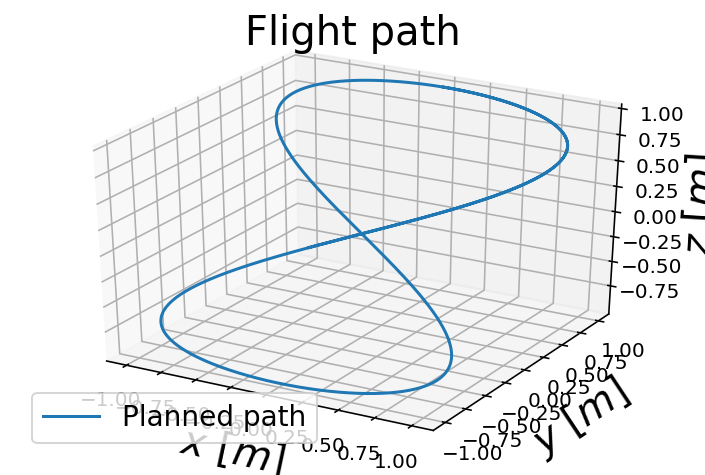

In [53]:
total_time = 20.0
dt = 0.01

t=np.linspace(0.0,total_time,int(total_time/dt))

omega_x = 0.8
omega_y = 0.4
omega_z = 0.4

a_x = 1.0 
a_y = 1.0
a_z = 1.0

x_path= a_x * np.sin(omega_x * t) 
x_dot_path= a_x * omega_x * np.cos(omega_x * t)
x_dot_dot_path= -a_x * omega_x**2 * np.sin(omega_x * t)

y_path= a_y * np.cos(omega_y * t)
y_dot_path= -a_y * omega_y * np.sin(omega_y * t)
y_dot_dot_path= -a_y * omega_y**2 * np.cos(omega_y * t)

z_path= a_z * np.cos(omega_z * t)
z_dot_path= -a_z * omega_z * np.sin(omega_z * t)
z_dot_dot_path= - a_z * omega_z**2 * np.cos(omega_z * t)

psi_path= np.arctan2(y_dot_path,x_dot_path)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x_path, y_path, z_path)
plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Planned path'],fontsize = 14)
plt.figure(figsize=(10,10))
plt.show()

### Plotting the drone's headings

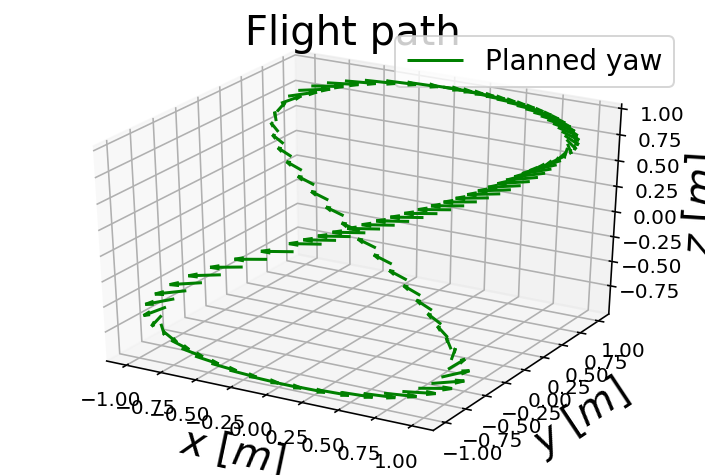

In [54]:
fig = plt.figure()
ax = fig.gca(projection='3d')

u = np.cos(psi_path)
v = np.sin(psi_path)
w = np.zeros(psi_path.shape)
for i in range(0,z_path.shape[0],20):
    ax.quiver(x_path[i], y_path[i], z_path[i], u[i], v[i], w[i], length=0.2, normalize=True,color='green')

plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Planned yaw',],fontsize = 14)

plt.show()

# Executing the flight

In this section, we will set up the entire system and will connect the drone object with the controller object. Next, execute the flight and compare the desired path with the executed one. 

x: delta = 0.816  omega_n = 2.449
y: delta = 0.816  omega_n = 2.449
z: delta = 0.354  omega_n = 1.414


/Users/felixramonlopezmartinez/opt/miniconda3/envs/fcnd/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


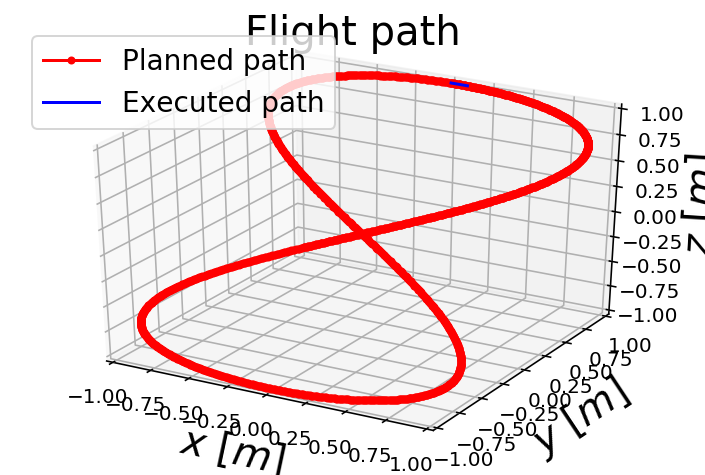

In [55]:
# how fast the inner loop (Attitude controller) performs calculations 
# relative to the outer loops (altitude and position controllers).
inner_loop_relative_to_outer_loop = 10

# creating the drone object
drone = DroneIn3D()
 
# creating the control system object 

control_system = Controller(z_k_p=2.0, 
                            z_k_d=1.0, 
                            x_k_p=6.0,
                            x_k_d=4.0,
                            y_k_p=6.0,
                            y_k_d=4.0,
                            k_p_roll=8.0,
                            k_p_pitch=8.0,
                            k_p_yaw=8.0,
                            k_p_p=20.0,
                            k_p_q=20.0,
                            k_p_r=20.0)



# declaring the initial state of the drone with zero
# height and zero velocity 

drone.X = np.array([x_path[0],
                               y_path[0],
                               z_path[0],
                               0.0,
                               0.0,
                               psi_path[0],
                               x_dot_path[0],
                               y_dot_path[0],
                               z_dot_path[0],
                               0.0,
                               0.0,
                               0.0])

# arrays for recording the state history, 
# propeller angular velocities and linear accelerations
drone_state_history = drone.X
omega_history = drone.omega
accelerations = drone.linear_acceleration()
accelerations_history= accelerations
angular_vel_history = drone.get_euler_derivatives()

# executing the flight
for i in range(0,z_path.shape[0]):
    
    rot_mat = drone.R()

    c = control_system.altitude_controller(z_path[i],
                                           z_dot_path[i],
                                           z_dot_dot_path[i],
                                           drone.X[2],
                                           drone.X[8],
                                           rot_mat)
    
    b_x_c, b_y_c = control_system.lateral_controller(x_path[i],
                                                     x_dot_path[i],
                                                     x_dot_dot_path[i],
                                                     drone.X[0],
                                                     drone.X[6],
                                                     y_path[i],
                                                     y_dot_path[i],
                                                     y_dot_dot_path[i],
                                                     drone.X[1],
                                                     drone.X[7],
                                                     c) 
    
    for _ in range(inner_loop_relative_to_outer_loop):
        
        rot_mat = drone.R()
        
        angular_vel = drone.get_euler_derivatives()
        
        u_bar_p, u_bar_q, u_bar_r = control_system.attitude_controller(
            b_x_c,
            b_y_c,
            psi_path[i],
            drone.psi,
            drone.X[9],
            drone.X[10],
            drone.X[11],
            rot_mat)
        
        drone.set_propeller_angular_velocities(c, u_bar_p, u_bar_q, u_bar_r)
        
        drone_state = drone.advance_state(dt/inner_loop_relative_to_outer_loop)
        
    # generating a history of the state history, propeller angular velocities and linear accelerations
    drone_state_history = np.vstack((drone_state_history, drone_state))
    
    omega_history=np.vstack((omega_history,drone.omega))
    accelerations = drone.linear_acceleration()
    accelerations_history= np.vstack((accelerations_history,accelerations))
    angular_vel_history = np.vstack((angular_vel_history,drone.get_euler_derivatives()))
    


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x_path, y_path, z_path,linestyle='-',marker='.',color='red')
ax.plot(drone_state_history[:,0],
         drone_state_history[:,1],
         drone_state_history[:,2],
         linestyle='-',color='blue')

plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Planned path','Executed path'],fontsize = 14)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

plt.show()


# Flight path comparison 

Comparing the desired heading and the actual heading (Yaw angle).

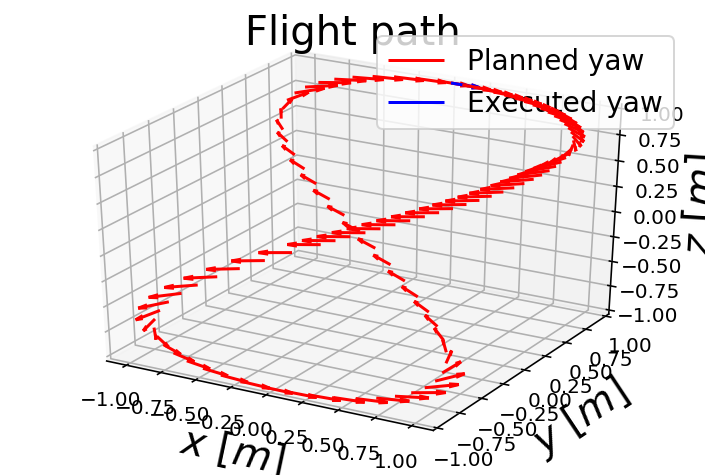

In [56]:
fig = plt.figure()
ax = fig.gca(projection='3d')

u = np.cos(psi_path)
v = np.sin(psi_path)
w = np.zeros(psi_path.shape)

drone_u = np.cos(drone_state_history[:,5])
drone_v = np.sin(drone_state_history[:,5])
drone_w = np.zeros(psi_path.shape)

for i in range(0,z_path.shape[0],20):
    ax.quiver(x_path[i], y_path[i], z_path[i], u[i], v[i], w[i], length=0.2, normalize=True,color='red')
    ax.quiver(drone_state_history[i,0], 
              drone_state_history[i,1], 
              drone_state_history[i,2], 
              drone_u[i], drone_v[i], drone_w[i], 
              length=0.2, normalize=True,color='blue')
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Planned yaw','Executed yaw'],fontsize = 14)

plt.show()

Calculating the error in position $\epsilon^2(t) = \left(x_t(t)-x_a(t)\right)^2 + \left(y_t(t)-y_a(t)\right)^2+ \left(z_t(t)-z_a(t)\right)^2$.

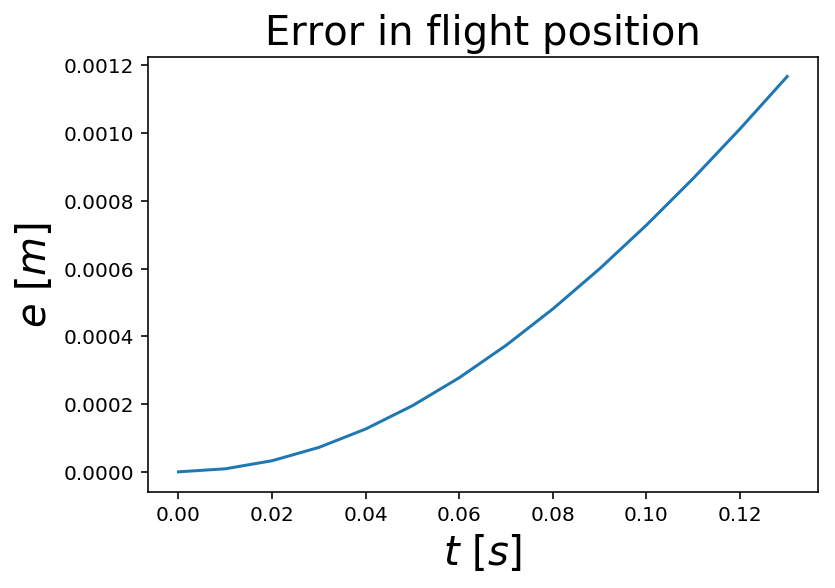

In [57]:
err= np.sqrt((x_path-drone_state_history[:-1,0])**2 
             +(y_path-drone_state_history[:-1,1])**2 
             +(y_path-drone_state_history[:-1,2])**2)


plt.plot(t,err)
plt.title('Error in flight position').set_fontsize(20)
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('$e$ [$m$]').set_fontsize(20)
plt.show()

Plotting the angular velocities of the propellers in time. 

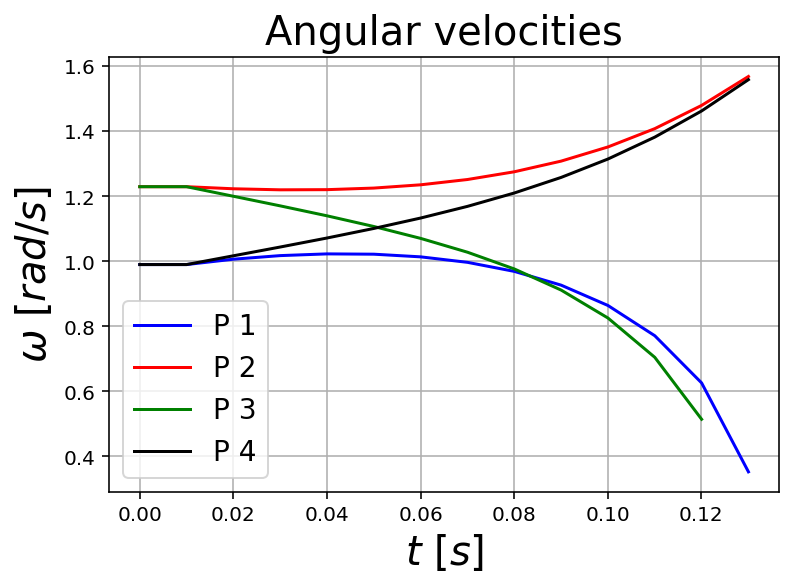

In [58]:
plt.plot(t,-omega_history[:-1,0],color='blue')
plt.plot(t,omega_history[:-1,1],color='red')
plt.plot(t,-omega_history[:-1,2],color='green')
plt.plot(t,omega_history[:-1,3],color='black')

plt.title('Angular velocities').set_fontsize(20)
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('$\omega$ [$rad/s$]').set_fontsize(20)
plt.legend(['P 1','P 2','P 3','P 4' ],fontsize = 14)

plt.grid()
plt.show()

Plotting the Yaw angle of the drone in time. 

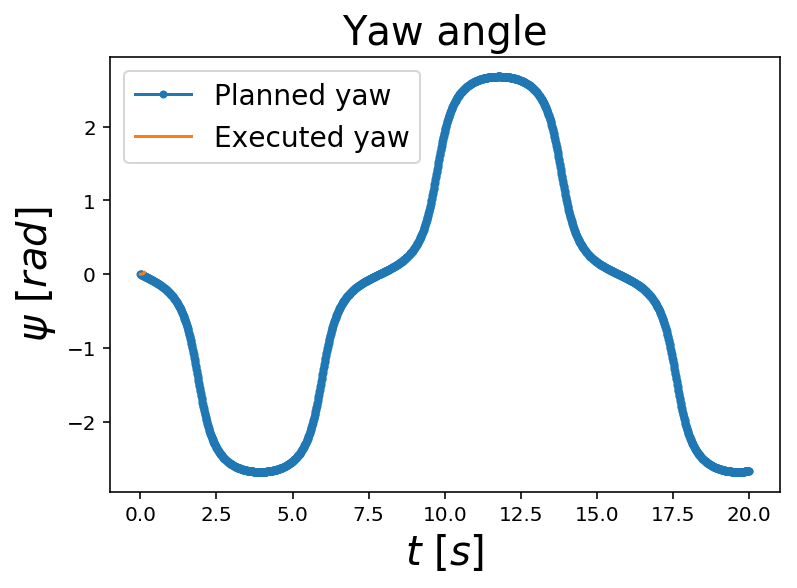

In [59]:
plt.plot(t,psi_path,marker='.')
plt.plot(t,drone_state_history[:-1,5])
plt.title('Yaw angle').set_fontsize(20)
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('$\psi$ [$rad$]').set_fontsize(20)
plt.legend(['Planned yaw','Executed yaw'],fontsize = 14)
plt.show()

[Solution](/notebooks/solution.py)